In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_247_png.rf.80a231d0c5dc022eb6db1d0c44f14982.jpg
/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_244_png.rf.7fa17fdd558d7d53bfcd039c354b5cd3.jpg
/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_318_png.rf.5f599054897a844872de2abd2817b498.jpg
/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_320_png.rf.881446b481b41f61f82d0aeb60af53e9.jpg
/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_323_png.rf.539d1cea73d4f26734c0ddcfa47561b2.jpg
/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_249_png.rf.012f72288d5be0ce92a40127b5b7096e.jpg
/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_333_png.rf.9f1e1ce7b6a86bb495a83c1bf7d43466.jpg
/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/HGIC_IndoorPlants_Mealybugs_5573436_1600.jpg
/kaggle/input/jute-pest1/Jute_Pest_Dataset/val/Mealybug/Citrus-mealybug-3-1.jpg
/kaggle/input/jute-pe

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to the same size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

In [3]:
traindataset = datasets.ImageFolder(root='/kaggle/input/jute-pest1/Jute_Pest_Dataset/train', transform=transform)
testdataset = datasets.ImageFolder(root='/kaggle/input/jute-pest1/Jute_Pest_Dataset/test', transform=transform)

In [4]:
train_loader = DataLoader(traindataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=4)


In [5]:
folder_path = '/kaggle/input/jute-pest1/Jute_Pest_Dataset/train'
class_names = [folder for folder in os.listdir(folder_path) 
                       if os.path.isdir(os.path.join(folder_path, folder))]
len(class_names)

17

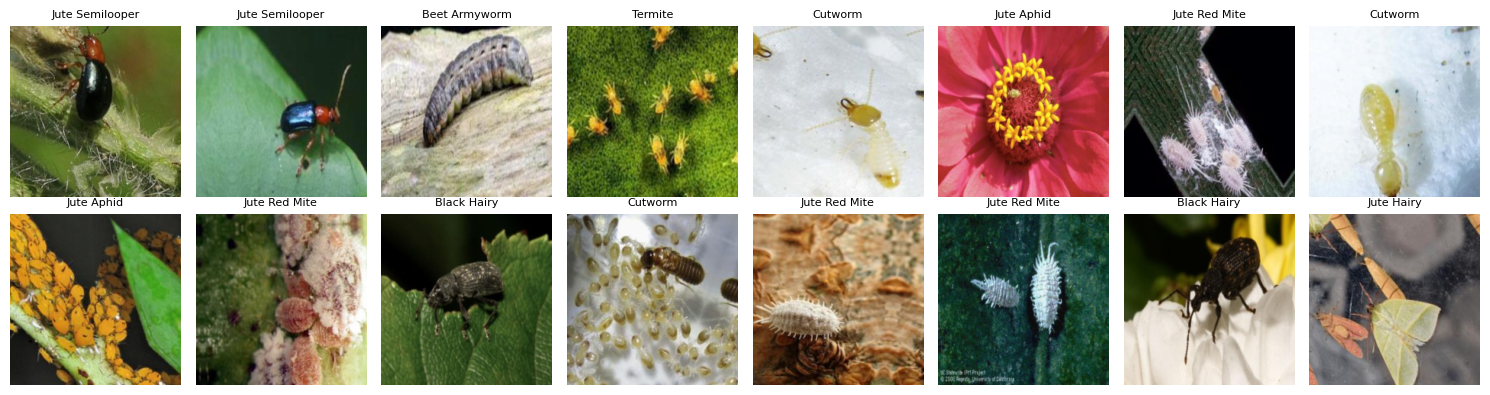

In [6]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def plot_batch(dataloader, classes):
    """
    Plots one batch of images from the DataLoader with labels under each image.

    Args:
        dataloader (DataLoader): The DataLoader object.
        classes (list): List of class names corresponding to labels.
    """
    # Get one batch of data
    images, labels = next(iter(dataloader))
    
    # Denormalize images if normalization was applied
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images = images * std + mean  # Denormalize images
    
    # Plot each image with its label
    batch_size = 16
    cols = 8  # Number of images per row
    rows = (batch_size + cols - 1) // cols  # Calculate the required number of rows
    
    plt.figure(figsize=(15, rows * 2))  # Adjust figure size based on rows
    for idx in range(batch_size):
        plt.subplot(rows, cols, idx + 1)
        img = images[idx].permute(1, 2, 0).numpy()  # Rearrange dimensions for matplotlib
        plt.imshow(img)
        plt.axis('off')  # Remove axes for better visualization
        label = classes[labels[idx].item()]  # Convert label index to class name
        plt.title(label, fontsize=8)  # Display label below the image
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_batch(train_loader, class_names)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvoluNet(nn.Module):
    def __init__(self, num_classes=17):
        super(ConvoluNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # (batch_size, 32, 224, 224)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # (batch_size, 64, 224, 224)
        self.relu2 = nn.ReLU()  # (batch_size, 64, 224, 224)
        self.bn2 = nn.BatchNorm2d(64)  # (batch_size, 64, 224, 224)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 64, 112, 112)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # (batch_size, 128, 112, 112)
        self.relu3 = nn.ReLU()  # (batch_size, 128, 112, 112)
        self.bn3 = nn.BatchNorm2d(128)  # (batch_size, 128, 112, 112)
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 128, 56, 56)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # (batch_size, 256, 56, 56)
        self.relu4 = nn.ReLU()  # (batch_size, 256, 56, 56)
        self.bn4 = nn.BatchNorm2d(256)  # (batch_size, 256, 56, 56)
        self.pool4 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 256, 28, 28)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)  # (batch_size, 512, 28, 28)
        self.relu5 = nn.ReLU()  # (batch_size, 512, 28, 28)
        self.bn5 = nn.BatchNorm2d(512)  # (batch_size, 512, 28, 28)
        self.pool5 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 512, 14, 14)

        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)  # (batch_size, 512, 14, 14)
        self.relu6 = nn.ReLU()  # (batch_size, 512, 14, 14)
        self.bn6 = nn.BatchNorm2d(512)  # (batch_size, 512, 14, 14)
        self.pool6 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 512, 7, 7)

        self.dropout = nn.Dropout(p=0.25)  # (batch_size, 512, 7, 7)

        self.flatten = nn.Flatten()  # (batch_size, 512 * 7 * 7 = 25088)

        self.fc1 = nn.Linear(in_features=7 * 7 * 512, out_features=1024)  # (batch_size, 1024)
        self.relu_fc1 = nn.ReLU()  # (batch_size, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)  # (batch_size, 1024)
        
        self.fc2 = nn.Linear(in_features=1024, out_features=512)  # (batch_size, 512)
        self.relu_fc2 = nn.ReLU()  # (batch_size, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)  # (batch_size, 512)
      
        self.fc3 = nn.Linear(in_features=512, out_features=256)  # (batch_size, 256)
        self.relu_fc3 = nn.ReLU()  # (batch_size, 256)
        self.bn_fc3 = nn.BatchNorm1d(256)  # (batch_size, 256)
        
        self.fc4 = nn.Linear(in_features=256, out_features=128)  # (batch_size, 128)
        self.relu_fc4 = nn.ReLU()  # (batch_size, 128)
        self.bn_fc4 = nn.BatchNorm1d(128)  # (batch_size, 128)
     
        self.fc5 = nn.Linear(in_features=128, out_features=32)  # (batch_size, 32)
        self.relu_fc5 = nn.ReLU()  # (batch_size, 32)
        self.bn_fc5 = nn.BatchNorm1d(32)  # (batch_size, 32)

        self.fc6 = nn.Linear(in_features=32, out_features=num_classes)  # (batch_size, num_classes)
        
    def forward(self, input):
        output = self.conv1(input)  # (batch_size, 32, 224, 224)
        output = self.conv2(output)  # (batch_size, 64, 224, 224)
        output = self.relu2(output)  # (batch_size, 64, 224, 224)
        output = self.bn2(output)  # (batch_size, 64, 224, 224)
        output = self.pool2(output)  # (batch_size, 64, 112, 112)
    
        output = self.conv3(output)  # (batch_size, 128, 112, 112)
        output = self.relu3(output)  # (batch_size, 128, 112, 112)
        output = self.bn3(output)  # (batch_size, 128, 112, 112)
        output = self.pool3(output)  # (batch_size, 128, 56, 56)
     
        output = self.conv4(output)  # (batch_size, 256, 56, 56)
        output = self.relu4(output)  # (batch_size, 256, 56, 56)
        output = self.bn4(output)  # (batch_size, 256, 56, 56)
        output = self.pool4(output)  # (batch_size, 256, 28, 28)

        output = self.conv5(output)  # (batch_size, 512, 28, 28)
        output = self.relu5(output)  # (batch_size, 512, 28, 28)
        output = self.bn5(output)  # (batch_size, 512, 28, 28)
        output = self.pool5(output)  # (batch_size, 512, 14, 14)

        output = self.conv6(output)  # (batch_size, 512, 14, 14)
        output = self.relu6(output)  # (batch_size, 512, 14, 14)
        output = self.bn6(output)  # (batch_size, 512, 14, 14)
        output = self.pool6(output)  # (batch_size, 512, 7, 7)

        output = self.dropout(output)  # (batch_size, 512, 7, 7)

        output = self.flatten(output)  # (batch_size, 25088)

        output = self.fc1(output)  # (batch_size, 1024)
        output = self.relu_fc1(output)  # (batch_size, 1024)
        output = self.bn_fc1(output)  # (batch_size, 1024)
     
        output = self.fc2(output)  # (batch_size, 512)
        output = self.relu_fc2(output)  # (batch_size, 512)
        output = self.bn_fc2(output)  # (batch_size, 512)
  
        output = self.fc3(output)  # (batch_size, 256)
        output = self.relu_fc3(output)  # (batch_size, 256)
        output = self.bn_fc3(output)  # (batch_size, 256)

        output = self.fc4(output)  # (batch_size, 128)
        output = self.relu_fc4(output)  # (batch_size, 128)
        output = self.bn_fc4(output)  # (batch_size, 128)
 
        output = self.fc5(output)  # (batch_size, 32)
        output = self.relu_fc5(output)  # (batch_size, 32)
        output = self.bn_fc5(output)  # (batch_size, 32)
          
        output = self.fc6(output)  # (batch_size, num_classes)

        # No need for softmax here if using CrossEntropyLoss
        # output = F.softmax(output, dim=1)  # (batch_size, num_classes)

        return output

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
model = ConvoluNet(num_classes =17).to(device)

In [10]:
from torch.optim import Adam
optimizer=Adam(model.parameters(),lr=0.01,weight_decay=1e-5)
loss_function=nn.CrossEntropyLoss()

In [11]:
epochs = 20

In [12]:
from tqdm import tqdm


def train(model, optimizer, loss_function, train_loader, epoch, epochs, train_count):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

    for i, (images, labels) in enumerate(train_bar):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().item() * images.size(0)  
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += torch.sum(prediction == labels.data).item()

        train_bar.set_postfix(train_loss=train_loss, train_accuracy=train_accuracy)

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    return train_loss, train_accuracy

def test(model, test_loader, test_count):
    model.eval()
    test_accuracy = 0.0
    test_loss = 0.0

    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item() * images.size(0)
        
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += torch.sum(prediction == labels.data).item()

    test_loss = test_loss / test_count
    test_accuracy = test_accuracy / test_count

    return test_loss, test_accuracy

In [13]:
train_count = len(traindataset)
test_count = len(testdataset)

In [14]:
import matplotlib.pyplot as plt

# Initialize lists to store values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

best_accuracy = 0.0

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, optimizer, loss_function, train_loader, epoch, epochs, train_count)
    test_loss, test_accuracy = test(model, test_loader, test_count)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print('Epoch: ' + str(epoch + 1) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

Epoch: 1 Train Loss: 2.457528412083082 Train Accuracy: 0.2090316573556797 Test Accuracy: 0.287598944591029


Epoch: 2 Train Loss: 2.1055147864669097 Train Accuracy: 0.2999689633767846 Test Accuracy: 0.29815303430079154


Epoch: 3 Train Loss: 1.8571069596496004 Train Accuracy: 0.3978895096213532 Test Accuracy: 0.41424802110817943


Epoch: 4 Train Loss: 1.7305951899878362 Train Accuracy: 0.44242706393544384 Test Accuracy: 0.44854881266490765


Epoch: 5 Train Loss: 1.574422543645275 Train Accuracy: 0.4941030415890751 Test Accuracy: 0.48812664907651715


Epoch: 6 Train Loss: 2.027322047249565 Train Accuracy: 0.3471446306641837 Test Accuracy: 0.2928759894459103


Epoch: 7 Train Loss: 1.7299542361945561 Train Accuracy: 0.43249534450651766 Test Accuracy: 0.47757255936675463


Epoch: 8 Train Loss: 1.6189635570266838 Train Accuracy: 0.4716014897579143 Test Accuracy: 0.49076517150395776


Epoch: 9 Train Loss: 1.432695111230913 Train Accuracy: 0.5339851024208566 Test Accuracy: 0.5013192612137203


Epoch: 10 Train Loss: 1.3490201265156305 Train Accuracy: 0.56967721911856 Test Accuracy: 0.45910290237467016


Epoch: 11 Train Loss: 1.8328517390511037 Train Accuracy: 0.42473618870266916 Test Accuracy: 0.39577836411609496


Epoch: 12 Train Loss: 1.8528585231207972 Train Accuracy: 0.3923029174425822 Test Accuracy: 0.3720316622691293


Epoch: 13 Train Loss: 1.6422755983140733 Train Accuracy: 0.4684978274363749 Test Accuracy: 0.47229551451187335


Epoch: 14 Train Loss: 1.4655840582613764 Train Accuracy: 0.5203289882060832 Test Accuracy: 0.554089709762533


Epoch: 15 Train Loss: 1.4792952716609544 Train Accuracy: 0.5204841713221602 Test Accuracy: 0.44327176781002636


Epoch: 16 Train Loss: 1.563917861674455 Train Accuracy: 0.4889819987585351 Test Accuracy: 0.5435356200527705


Epoch: 17 Train Loss: 1.420799407361088 Train Accuracy: 0.5339851024208566 Test Accuracy: 0.48812664907651715


Epoch: 18 Train Loss: 1.3864636051218233 Train Accuracy: 0.5465549348230913 Test Accuracy: 0.45118733509234826


Epoch: 19 Train Loss: 1.4339476569256822 Train Accuracy: 0.5403476101800124 Test Accuracy: 0.48021108179419525


Epoch: 20 Train Loss: 1.2765506934409256 Train Accuracy: 0.5816263190564867 Test Accuracy: 0.5725593667546174


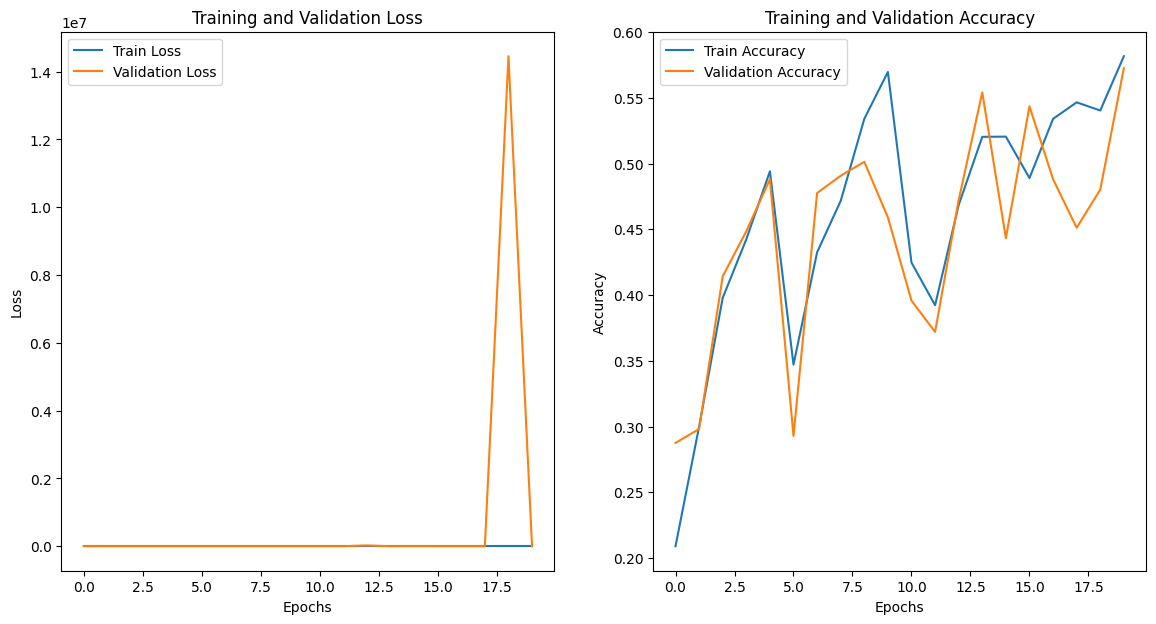

In [15]:
epochs_range = range(epochs)

plt.figure(figsize=(14, 7))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label
         ='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()